This notebook reproduces the simulation study in vdLaan 2006 subsection 6.4.  It implements TMLE updates for Q and g, and compares the resulting estimators of the average treatment effect (ATE).

In [1]:
# Load packages
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt 
from itertools import combinations_with_replacement as combs

def cb(*args): return np.array(args).transpose() #Reshapes A,W to fit as covariates for linear regression.

### Define all functions

In [2]:
#The ground truth functions
def Q0(a,w):
    return -a*(8*w**2 -8*w+1) - (1-a)*2/3

def g0(w):
    return 1/(1+np.exp(-8*w**2 +8*w-1))

In [3]:
#Ground truth ATE
psi = Q0(1,np.random.uniform(size=1000000)).mean()-Q0(0,np.random.uniform(size=1000000)).mean()
psi

1.0006972453856195

In [4]:
#Define a function which samples a dataset
def sample(n):
    W = np.random.uniform(size=n)
    A = np.random.binomial(1,p=g0(W),size=n)
    e = np.random.normal(size=n)
    Y = Q0(A,W)+e
    return W,A,Y

In [5]:
#Define the three estimators
def h(a,w,g):
    return a/g(w) - (1-a)/(1-g(w))

def psi1(Q,w):
    return np.mean(Q(np.ones(len(w)),w)-Q(np.zeros(len(w)),w))

def psi2(a,w,y,g):
    return np.mean(y*h(a,w,g))

def psi3(a,w,y,g,Q):
    return psi1(Q,w) + psi2(a,w,y,g) -np.mean(h(a,w,g)*Q(a,w))

In [6]:
#Define a function which creates an initial estimate of Q based on the regression Y~A+W
def makeQ(A,W,Y):
    reg = LinearRegression().fit(cb(A,W), Y)
    cache_val = reg.predict(cb(A,W))
    def Q(a,w):
        if a.shape==A.shape: 
            if (a==A).all() and (w==W).all():
                return cache_val
        return reg.predict(cb(a, w))
    return Q

In [7]:
#Define a function factory which updates Q according to the TMLE step

def updateQ(Q,g,A,W,Y, print_eps=False):
    eps = np.sum(h(A,W,g)*(Y-Q(A,W))) / np.sum(np.square(h(A,W,g)))
    if print_eps:
        print(eps)
    
    cache_val = Q(A,W) + eps * h(A,W,g) #The value Q(A,W) will be called ALOT, so we cache it.
    
    def Qnew(a,w):
        if a.shape==A.shape: 
            if (a==A).all() and (w==W).all():
                return cache_val
        return Q(a,w) + eps * h(a,w,g)
    return Qnew

In [8]:
## Implement Newtown-rhapson from scratch to fit the logistic regression because...

def logit(x):
    return np.log(x/(1-x))

def logist(y):
    return 1/(1+np.exp(-y))

def h2(w,Q,g):
    return Q(np.ones(len(w)),w)/(g(w)) + Q(np.zeros(len(w)),w)/(1-g(w))

def like_grad(theta,W,A,Q,g):
    X = h2(W,Q,g)
    eta = logit(g(W)) + theta*X
    Y = logist(eta)-A
    return Y@X

def like_hess(theta,W,A,Q,g):
    X = h2(W,Q,g)
    eta = logit(g(W)) + theta*X
    return np.sum(logist(eta)*(1-logist(eta))*np.square(X))

def newton_rhaps(W,A,Q,g,start=0,tol = 10**(-5), iters = 10):
    theta = start

    for i in range(iters):
        delta = -like_grad(theta,W,A,Q,g)/(like_hess(theta,W,A,Q,g))
        theta = theta + delta/((i+1)**(0.5))
        if abs(delta) < tol:
            break
    return theta

In [9]:
# Use the Newton-Rhapson to update g:

def updateg(Q,g,A,W,Y,print_eps=False):
    eps = newton_rhaps(W,A,Q,g)
    if print_eps:
        print(eps)
    
    cache_val = logist(logit(g(W)) + eps*h2(W,Q,g)) #again we cache the values g(W)
    
    def gnew(w):
        if w.shape==W.shape: 
            if (w==W).all():
                return cache_val
        return logist(logit(g(w)) + eps*h2(w,Q,g))
    return gnew

### Try one sample

In [10]:
np.random.seed(1)
W,A,Y = sample(200)
Qi = makeQ(A,W,Y)

In [11]:
## Truth estimates vs intitial estimates
print("estimates based on truth ", [psi1(Q0,W),psi2(A,W,Y,g0), psi3(A,W,Y,g0,Q0)])
print("estimates based on Q_init", [psi1(Qi,W),psi2(A,W,Y,g0), psi3(A,W,Y,g0,Qi)])

estimates based on truth  [0.9182409739883178, 0.8211035967395494, 0.772297221743565]
estimates based on Q_init [0.6067579395067444, 0.8211035967395494, 0.776887846393176]


In [12]:
## Target Q
Q1 = updateQ(Qi,g0,A,W,Y)
[psi1(Q1,W),psi2(A,W,Y,g0), psi3(A,W,Y,g0,Q1)]

[0.7746912770411178, 0.8211035967395494, 0.7746912770411177]

In [13]:
#try updating Q again with same g and verify that epsilon is small:
Q1 = updateQ(Q1,g0,A,W,Y,print_eps=True) 

1.1746469272005708e-17


In [14]:
## Target g
g1 = updateg(Q1,g0,A,W,Y)
[psi1(Q1,W),psi2(A,W,Y,g1), psi3(A,W,Y,g1,Q1)]

[0.774691277041118, 0.7736424348309447, 0.7731623890297141]

In [15]:
# Sufficient targeting steps of Q and g
for i in range(4):
    Q1 = updateQ(Q1,g1,A,W,Y,print_eps=True)
    g1 = updateg(Q1,g1,A,W,Y,print_eps=True)
[psi1(Q1,W),psi2(A,W,Y,g1), psi3(A,W,Y,g1,Q1)]

-0.00033875430955021465
0.0011668221812283594
1.0374095096319549e-06
5.846503962711941e-06
5.341229208004456e-09
2.9209140875615798e-08
2.6688338794926424e-11
1.4594156505566769e-10


[0.7731801548444486, 0.7731801548453363, 0.7731801548450504]

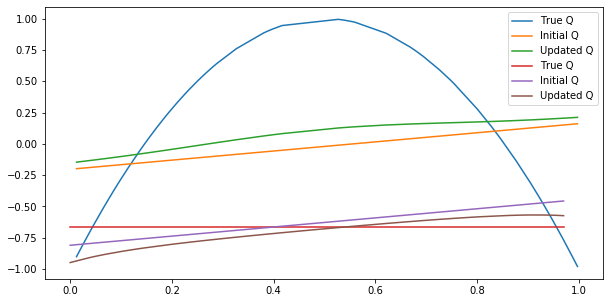

In [16]:
## Plot the targeted Q and g:

w0 = W[A==0]
w0.sort()
w1 = W[A==1]
w1.sort()

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(w1,Q0(A[A==1],w1), label = "True Q")
plt.plot(w1,Qi(A[A==1],w1), label = "Initial Q")
plt.plot(w1,Q1(A[A==1],w1), label = "Updated Q")

plt.plot(w0,Q0(A[A==0],w0), label = "True Q")
plt.plot(w0,Qi(A[A==0],w0), label = "Initial Q")
plt.plot(w0,Q1(A[A==0],w0), label = "Updated Q")

plt.legend()
plt.show()

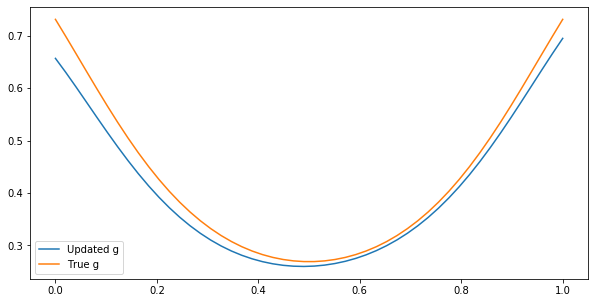

In [17]:
plt.plot(np.linspace(0,1),g1(np.linspace(0,1)),label = "Updated g")
plt.plot(np.linspace(0,1),g0(np.linspace(0,1)),label = "True g")
plt.legend()
plt.show()

### Simulate a lot of datasets

In [18]:
def simulation(n=200, N=1000):
    l = []
    
    for i in tqdm(range(N)):
        W,A,Y = sample(n)

        Qi = makeQ(A,W,Y)

        p1,p2,p3 = psi1(Qi,W),psi2(A,W,Y,g0), psi3(A,W,Y,g0,Qi)
        
        Q1 = updateQ(Qi,g0,A,W,Y)
        p4,p5 = psi1(Q1,W), psi3(A,W,Y,g0,Q1)
        
        g1 = updateg(Q1,g0,A,W,Y)
        
        for i in range(5):
            Q1 = updateQ(Q1,g1,A,W,Y)
            g1 = updateg(Q1,g1,A,W,Y)
        p6,p7,p8 = psi1(Q1,W),psi2(A,W,Y,g1), psi3(A,W,Y,g1,Q1)
        
        p9 = psi3(A,W,Y,g0,Q0)
        
        l.append(np.array([p1,p2,p3,p4,p5,p6,p7,p8,p9]))
    
    return np.array(l)

In [22]:
l = simulation(n=100)

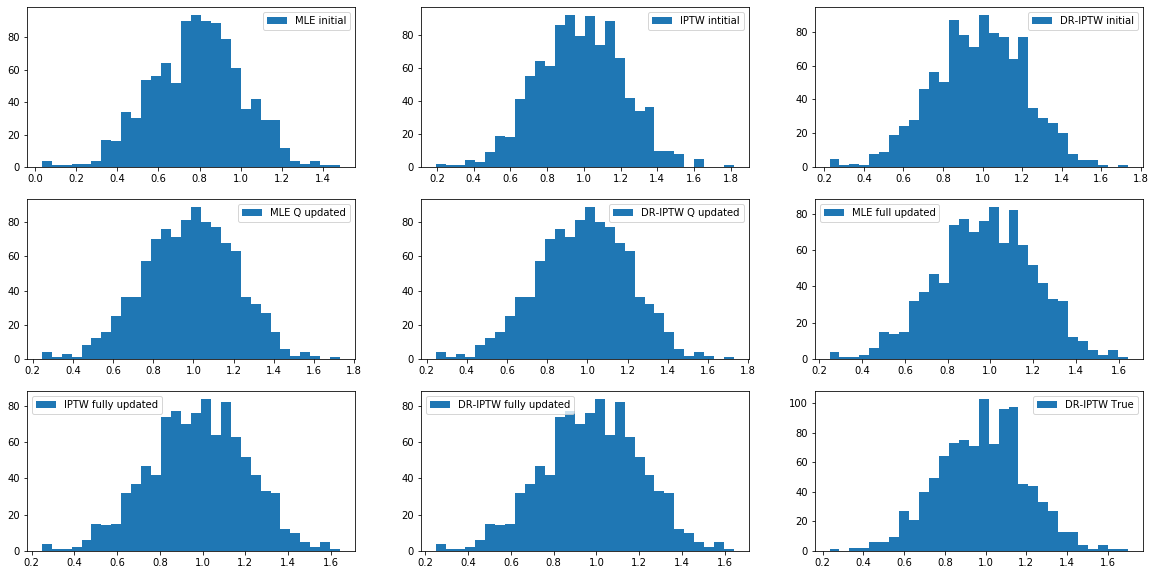

In [23]:
#plot histograms
fig, axs = plt.subplots(3,3,figsize=(20,10))

labels = ["MLE initial", "IPTW intitial", "DR-IPTW initial", "MLE Q updated","DR-IPTW Q updated",
         "MLE full updated", "IPTW fully updated", "DR-IPTW fully updated", "DR-IPTW True"]
for i in range(9):
    axs[i//3,i%3].hist(l[:,i],30,label = labels[i])
    axs[i//3,i%3].legend()
plt.show()

In [24]:
# Relative efficiencies
for i in range(8):
    print(np.sum(np.square(l[:,i]-psi))/np.sum(np.square(l[:,8]-psi)), labels[i])

2.0287468406655673 MLE initial
1.1749916958593059 IPTW intitial
1.1785130959110781 DR-IPTW initial
1.132906774586287 MLE Q updated
1.1329067745862873 DR-IPTW Q updated
1.1258614825839461 MLE full updated
1.125748068839182 IPTW fully updated
1.1258829578397913 DR-IPTW fully updated
